# Introduction to Population Receptive Field models

### by Sam Schwarzkopf
Notebook version by Jan Freyberg

Before the start of the actual cookbook on using SamSrf for population receptive field (pRF) mapping, here is a basic introduction to how our method works. The procedure is largely based on [Dumoulin & Wandell, 2008, NeuroImage, 39(2):647-60](https://www.ncbi.nlm.nih.gov/pubmed/17977024). You may want to read this article.

### What is a pRF?

As any text book on neurophysiology will tell you, a neuron’s receptive field is the region of space that can excite the neuron when we put a stimulus in it. “Space” can mean a lot of things in this context. Most frequently, people will mean visual space, that is, retinotopic location. However, there are other stimulus spaces, such as maps of the frequency of a tone or locations on your skin. In fact, as a certain student in our lab frequently put it, receptive fields are really just a special form of tuning function. A visual receptive field is just a tuning function for position in visual space. So in essence what we want to do is map tuning functions for a particular stimulus space – and this could be anything, be it visual position, sound frequency, selectivity to particular objects, your location in the environment, or even things like language. So don’t let anyone tell you that pRF models are just a fancy form of retinotopic mapping. There is potential for so much more.

Naturally, we are not measuring single neurons but the activity of a large number of neurons combined (and through an indirect, metabolic measure of activity). This is why we call it a population receptive field. The properties of the pRF are not necessarily an up-scaled version of the receptive fields of single neurons. The pRF will contain those parameters but is also dependent on the scatter of the individual receptive fields, and it incorporates the extra-classical or contextual interactions between neurons within (and outside) the population.

Last but not least, the acronym is spelled with a lower case p for some arcane reasons. This is probably in reference to the fact that in the neurophysiology world there are such things as classical receptive fields that are abbreviated as cRF. For all I care you can spell it PRF.

### How do we map pRFs?

Simply put, for each population of neurons in the brain we want to estimate the parameters of the pRF from the fMRI (or other?) data we collected. The parameters of the pRF can be many things. In a simple case it would be the position (in Cartesian coordinates, x0 and y0) and the spatial spread of the pRF (since we use a 2D-Gaussian model, this is called σ, i.e. sigma). But more complex receptive field models are also possible, such as antagonistic centre-surround profiles (modelled as a difference-of-Gaussians function), or even oriented or asymmetric profiles. Putting together all the parameters for neighbouring points on the cortical sheet gives us a map for this parameter.

In order to estimate these parameters we need to have two sets of information: the observed data (i.e. the fMRI time series) and the time series of the stimulus. In SamSrf the latter is called the __stimulus apertures__, but that’s just a fancy name for a small movie of the stimulus we presented to participants during the scan. In fact, it is usually a simplified version of the stimulus that just encodes whether or not a stimulus was present at each location in the visual field at a given time.

Armed with these two things we can now create a pRF model. What we need to do is find the pRF parameters (like position and size) that can best explain the observed time series. We can predict the time series a particular receptive field profile would produce if faced with the apertures of our stimulus sequence. At each moment in time (i.e. each TR of our fMRI scan) we calculate the overlap between the stimulus aperture and the receptive field profile. As already described, the apertures are just a movie. The receptive field profile is simply an image of the receptive field and we multiply this image, pixel-by-pixel, with each frame of the aperture movie in turn. You can try this for yourself using the functions that come with SamSrf.

Run the cell below (click inside it, and then press `Ctrl + Enter`)

In [1]:
LargeRF = prf_gaussian_rf(0.5, 0.5, 1);
SmallRF = prf_gaussian_rf(-0.5, 0.5, .1);

You can then visualise these with `imshow` - do so by selecting the cell below and running it.

You'll see one RF is in the upper right visual field (coordinates 0.5, 0.5) and very large, while the other is in the upper left visual field (-0.5, 0.5) and very small:

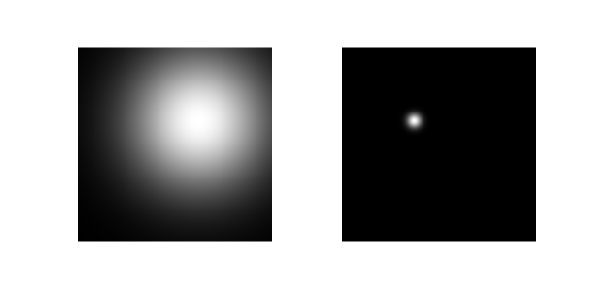

In [2]:
%plot -s 600,300
figure;
subplot(1, 2, 1);
imshow(LargeRF);
subplot(1, 2, 2);
imshow(SmallRF);

Next you want to load a stimulus aperture movie. You will have one if you run a pRF mapping experiment but if you don’t, ask one of the people who have done the analysis already. This is stored in a variable called _ApFrm_. We can predict the time series each of these receptive field profiles would produce using the following function:

In the top row you see the receptive field profile on the left, the stimulus aperture at the current time point in the middle, and the overlap between the two on the right. In the bottom row we see the predicted response of this hypothetical receptive field.

Of course, because we are measuring BOLD signals with fMRI our time series does not reflect the underlying neural activity directly. Therefore, we have to convolve the predicted time series with the haemodynamic response function (HRF). For this we can either take a canonical HRF, or measure the HRF specifically for each subject and use this. The latter approach is probably better because it takes the individual differences in the HRF into account. However, the maps themselves should be relatively robust to different HRFs, so if the pRF sizes are less important to you the use of a canonical HRF may be acceptable.


### Fitting pRF models

The tricky thing we must do now is to find the receptive field profile (or more precisely its associated parameters) that can produce a time series that matches the observed time series. What we therefore need to do is fit a model with several free parameters (in this case at least three) to the observed data. Ideally we want to do this straight out of the box but this is tedious and difficult. So what we can do is apply a coarse-to-fine approach in which we first find a way to disambiguate the parameters and then refine them further. There are several ways one could do this and some of them have been incorporated in SamSrf:

1. __Simple Gaussian__: In this most basic procedure we first smooth the data very heavily on the cortical surface. This gives a very crude, blurry map but it has the benefit of allowing a fairly decent fit. This is called the coarse fit. We then use these blurry maps to optimise the parameters at each cortical location (called vertices) but using the unsmoothed raw data. For the sake of saving time we only take those vertices for which we had a reasonable coarse fit and we limit the parameters to a small range around those derived from the coarse fit. This stage is therefore called the slow fine fit. The coarse fit works by maximising the Pearson correlation between the observed data and the fitted model. The fine fit, however, minimises the squared residuals between model and data. Therefore, it includes a beta parameter to estimate the amplitude of the signal in the data. At the end we smooth the parameter maps again a little to reduce the noisiness in the results.

2. __Simple Gaussian (smoothed)__: This is an older procedure. Here we first smoothed the data before fitting the pRF model and we did not include any crude smoothing in the coarse fit. The pre-smoothing can either be done on the cortical surface or in the volume via SPM. This procedure will save some time and can produce very nice maps (because smoothing helps the signal-to-noise ratio of your time series) – however, the pRF size estimates will be inflated because we are using spatially correlated signals.

3. __Simple Gaussian (fast fit)__: This procedure uses an extensive grid search algorithm only. It is therefore only the coarse fit used in the normal model fitting but with a much finer search space. It fit a beta parameter with a GLM after the main parameter fitting because for that is uses Pearson’s correlation which is independent of scale. While the model fitting will be reasonably fast, generating the search space will take a long time so it is advisable to reuse that for different subjects. You can use these fast fits as the coarse fit to initialise a normal slow fit. For that rename the `_ff.mat` files to `_cf.mat` files!

4. __Difference-of-Gaussians__: This procedure models centre-surround antagonistic receptive fields. It uses the same coarse fitting approach as the Simple Gaussian models and you can simply use the same coarse fitted maps. But at the fine-fitting stage we estimate more parameters: in addition to position (`x0` and `y0`), we have two sigmas (one for the centre, one for the surround) and a parameter for the ratio of the amplitudes of the two components.

5. __Reverse Correlation__: This procedure uses a model-free approach to estimate the pRF profile. It convolves the stimulus apertures with the HRF, then multiples the activity measured in each fMRI volume with these apertures, and finally averages the frames for all the volumes together. This gives an image that reflects at which location the voxel showed the strongest response. Because our stimuli are usually temporally ordered and predictable designs there will be a lot of correlation throughout the image (e.g. with a bar stimulus you will see a set of bars intersecting at the pRF location). Some filtering is therefore applied to minimise these artifacts whilst retaining the (presumably) true pRF. These pRF profiles are then saved and the `x` and `y` coordinates of the pRF are established. No further modelling is applied so you cannot quantify pRF size or shape without further processing. The lack of model fitting makes this procedure comparably fast.

6. __Gaussian Curve__: This procedure is very similar to the standard pRF approach except that it is fitting a one-dimensional tuning curve rather than a two-dimensional receptive field. The apertures in this case are a two-dimensional matrix with 100 columns covering the stimulus space (whatever that may be – e.g. tonotopy) and as many rows as there are volumes. For these fits it is probably essential to include baseline volumes which should be labelled as `NaN` (this can be done with all procedures but it is not critical there). The tuning curve is modelled as a Gaussian and it assumes that the stimulus space is linear. So if your stimulus dimension is non-linear you must log-transform it first.

7. __Von Mises Curve__: This is the same as the Gaussian Curve model except that this assumes a circular stimulus space (e.g. orientation) and therefore fits a Von Mises function rather than a Gaussian. The apertures must contain 360 columns to represent the stimulus space in degrees.

8. __Multivariate Gaussian__: This is an oriented elliptical Gaussian so this has two pRF size parameters and an orientation parameter.

### How does the coarse fit work?

The coarse fit should really be called brute-force approach. We first create an enormous variable called search space that contains the time series predicted by every combination of different values x0, y0, and σ could possibly take. The accuracy of the coarse fit thus depends on how finely sampled this search space is. At the very least there should be several thousand different predictions. Generating these predictions can take quite a long time – but they are going to be the same if you keep the stimulation sequence of your mapping procedure the same across subjects. Therefore, you only really need to generate this once provided you collect the same amount of data in the same sequence for each subject!

For each vertex we then find the best fitting prediction in the search space by calculating the Pearson correlation between the observed data and this prediction matrix. The good thing about this is that we can do this simultaneously for many vertices at the same time, which makes the coarse fitting procedure relatively fast (Unfortunately, this appears to only work in MATLAB R2011b and higher. On older versions you still need to do it the old-fashioned, snails- pace way and I’m afraid that takes ages...). Once we have the best correlated prediction we can simply pick the parameters from that prediction and that is the coarse fit.

### Surface projection

One last thing you should know about how the analysis in SamSrf works is surface projection. FreeSurfer’s automatic cortical reconstruction creates a 3D model of the boundary between grey and white matter. This is a mesh consisting of over 100,000 little points (vertices) that are connected to one another in an even greater number of tiny little triangles (faces). FreeSurfer also expands this surface until it hits the pial boundary between grey matter and cerebrospinal fluid. Thus for each vertex on the grey-white mesh there is a corresponding vertex in the pial mesh. We can use this to find points that lie within the grey matter and locate which voxels those correspond to in our functional MRI scans. This is what we do when we project the fMRI data onto the cortical surface. All of SamSrf’s analyses take place on the surface.
FreeSurfer further inflates the cortical meshes to smooth out the cortical folding structure. This is helpful for displaying the data on the cortical sheet and delineating maps. Finally, it also expands these inflated meshes to a spherical mesh. This can be used to combine data from different individuals. It is also extremely useful for surface-based (geodesic) operations that we need in the analysis (e.g. smoothing, field sign calculation, etc.).

### Overview of pRF pipeline

Before delving into SamSrf analysis proper, lets look at the overall plan for data analysis in pRF modelling. The analysis takes place in three component streams: pre-processing in an fMRI package of your choice (e.g. SPM), surface reconstruction and display in Freesurfer and pRF modelling in SamSrf. Between these streams, the whole analysis can be broken down into a set of 5 main steps:

1. fMRI pre-processing

2. Anatomical reconstruction

3. Surface-projection of functional data

4. pRF modelling (with inputs from all previous steps) 5. Displaying results and area delineation in Freesurfer

<img src="img/samsrf-pipeline.png" width="400">

Use the other notebooks to go through actually fitting a pRF.